In [1]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from wwo_hist import retrieve_hist_data
import pandas as pd
import xgboost
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from seffaflik.elektrik import uretim

today = datetime.today().strftime('%Y-%m-%d')
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
presentday = datetime.now()
tomorrow = (presentday + timedelta(1)).strftime('%Y-%m-%d')


start = pd.to_datetime('2019-01-01')
end = pd.to_datetime('2021-09-08')
rng = pd.date_range(start, end, freq='H')
len(rng)
rng = rng[0:-1]
len(rng)
rng = pd.DataFrame(rng)
rng = rng.set_axis(['DateTime'], axis=1)

def plottingresults(validation,prediction,label):
    x_ax = range(len(validation))
    plt.plot(x_ax, list(validation), linewidth=1.5, label="original")
    plt.plot(x_ax, list(prediction), linewidth=1.5, label="predicted")
    plt.title(label)
    plt.xlabel('Hours')
    plt.ylabel('MWh')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

In [2]:
#%% Initialize XGBoostRegression

def XGBoostRegression(X_train,y_train,X_test):
    parameters_for_testing = {
    'colsample_bytree':[0.4],
    'gamma':[0,0.1,0.3],
    'min_child_weight':[10],
    'learning_rate':[0.01, 0.1, 0.2, 0.3],
    'max_depth':[3,5],
    'n_estimators':[200],
    'reg_alpha':[1e-5],
    'reg_lambda':[1e-5],
    'subsample':[0.6,0.95]  
    }
                    
    xgb_model = xgboost.XGBRegressor(learning_rate = 0.1, n_estimators=1000, max_depth=5,
                                      min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)
    
    gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,verbose=10,scoring='neg_mean_squared_error')
    gsearch1.fit(X_train,y_train)
    print (gsearch1.best_params_)
    print('best score')
    print (gsearch1.best_score_)
    Xgbpred = gsearch1.predict(X_test)

    return Xgbpred

In [3]:
#%% IMPORT EPIAS PRODUCTION
Target = uretim.gerceklesen(baslangic_tarihi='2019-01-01', bitis_tarihi='2021-09-07', santral_id = "2285")
Target['DateTime'] = pd.to_datetime(Target.Tarih) + Target.Saat.astype('timedelta64[h]')
Target = Target.set_index('DateTime')
Target = pd.DataFrame(Target['Rüzgar'])

In [4]:
#%% IMPORT WORLDWEATHER
frequency=1
start_date = '01-JAN-2019'
end_date = '07-SEP-2021'
api_key = 'beb3f237e0274253b3764922210712'
location_list = ['37.60,31.67']
hist_weather_data = retrieve_hist_data(api_key,location_list,start_date,end_date,frequency,location_label = False,
                                       export_csv = False, store_df = True)
df = hist_weather_data[0]
df['hour'] = pd.DatetimeIndex(df['date_time']).hour
df['month'] = pd.DatetimeIndex(df['date_time']).month
df = df.set_index('date_time')



Retrieving weather data for 37.60,31.67


Currently retrieving data for 37.60,31.67: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.939233
Currently retrieving data for 37.60,31.67: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.331637
Currently retrieving data for 37.60,31.67: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.854952
Currently retrieving data for 37.60,31.67: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:06.047883
Currently retrieving data for 37.60,31.67: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:00:07.303466
Currently retrieving data for 37.60,31.67: from 2019-06-01 to 2019-06-30
Time elapsed (hh:mm:ss.ms) 0:00:09.325137
Currently retrieving data for 37.60,31.67: from 2019-07-01 to 2019-07-31
Time elapsed (hh:mm:ss.ms) 0:00:10.422355
Currently retrieving data for 37.60,31.67: from 2019-08-01 to 2019-08-31
Time elapsed (hh:mm:ss.ms) 0:00:11.706485
Currently retrieving data for 37.60,

In [5]:
#%% Feature Elimination
eliminationfeature=["maxtempC","mintempC","sunHour","uvIndex",
                    "moon_illumination","moonrise","moonset",
                    "sunrise","sunset","DewPointC","FeelsLikeC",
                    "HeatIndexC","WindChillC","visibility","location"]
for feature in eliminationfeature:
    df = df.drop(feature, axis = 1)

df = df.astype(float)

df['Sin_windspeedKmph'] = np.sin(df['windspeedKmph'])
df['Cos_windspeedKmph'] = np.cos(df['windspeedKmph'])

df.index = df.index.rename('DateTime')
df = pd.merge(df, rng, on="DateTime", how="outer")

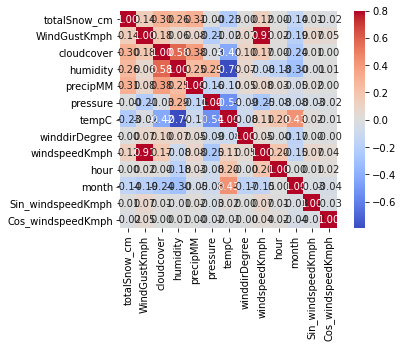

In [6]:
#%% Correlation matrix
import seaborn as sns
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, vmax=.8, square=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)
plt.show()

In [7]:
#%% CUT-OFF AND ERROR VALUES
Target = pd.merge(Target, rng, on="DateTime", how="outer")

Target = Target.sort_values(by='DateTime', ascending=True)

df = df.set_index('DateTime')
Target = Target.set_index('DateTime')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [   0    1    2 ... 3921 3922 3923] VALIDATION: [3924 3925 3926 ... 7845 7846 7847]
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-34.934745816806455


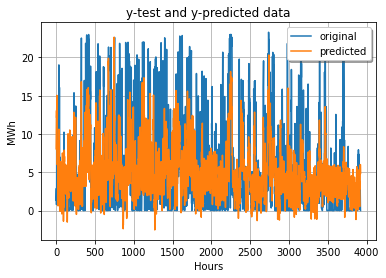

TRAIN: [   0    1    2 ... 7845 7846 7847] VALIDATION: [ 7848  7849  7850 ... 11769 11770 11771]
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-28.644978843450815


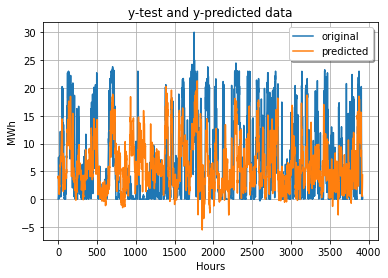

TRAIN: [    0     1     2 ... 11769 11770 11771] VALIDATION: [11772 11773 11774 ... 15693 15694 15695]
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-30.292481285909805


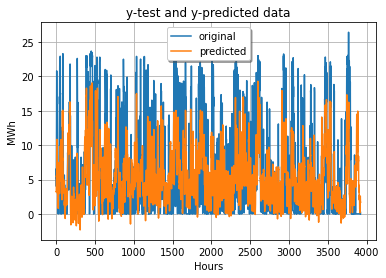

TRAIN: [    0     1     2 ... 15693 15694 15695] VALIDATION: [15696 15697 15698 ... 19617 19618 19619]
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.95}
best score
-29.535716209020713


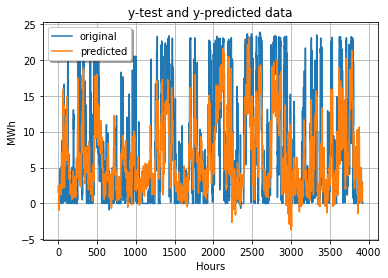

TRAIN: [    0     1     2 ... 19617 19618 19619] VALIDATION: [19620 19621 19622 ... 23541 23542 23543]
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-29.466014816373708


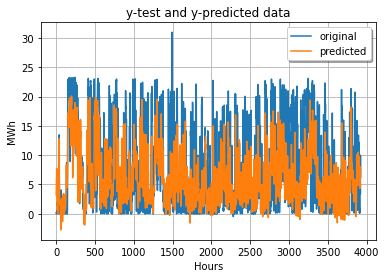

In [8]:
#%% TRAINING AND VALIDATION SET NESTED - CROSS VALIDATION
df = df.values
Target = Target.values

k = 0
n_splits=5

tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
Xgbpred = pd.DataFrame(columns=np.arange(0,n_splits,1)).fillna(0)
maevalues = np.zeros(n_splits)
X_train_append = []
y_train_append = []
X_val_append = []
y_val_append = []
print(tscv)
for train_index, val_index in tscv.split(df):
    print("TRAIN:", train_index, "VALIDATION:", val_index)    
    X_train, X_val = df[train_index], df[val_index]
    y_train, y_val = Target[train_index], Target[val_index]
    X_train_append.append(X_train), y_train_append.append(y_train), X_val_append.append(X_val), y_val_append.append(y_val)
    Xgbpred[k] = XGBoostRegression(X_train,y_train,X_val)
    maevalues[k] = mean_absolute_error(y_val, Xgbpred[k])
    plottingresults(y_val,Xgbpred[k],"y-test and y-predicted data")
    k = k + 1
maevalues = list(maevalues)

In [10]:
#%% TEST SET
start_date = '2022-01-29'
end_date = '2022-01-30'
hist_weather_data2 = retrieve_hist_data(api_key, location_list,
                                        start_date, end_date, 
                                        frequency, location_label = False, 
                                        export_csv = False, store_df = True)

X_test = hist_weather_data2[0]
X_test = X_test[24:]
X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month
X_test = X_test.set_index('date_time')

for feature in eliminationfeature:
    X_test = X_test.drop(feature, axis = 1)

X_test = X_test.astype(float)

X_test['Sin_windspeedKmph'] = np.sin(X_test['windspeedKmph'])
X_test['Cos_windspeedKmph'] = np.cos(X_test['windspeedKmph'])
X_test = X_test.values



Retrieving weather data for 37.60,31.67


Currently retrieving data for 37.60,31.67: from 2022-01-29 to 2022-01-30
Time elapsed (hh:mm:ss.ms) 0:00:00.353699


<ipython-input-10-7033df3a753f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['hour'] = pd.DatetimeIndex(X_test['date_time']).hour
<ipython-input-10-7033df3a753f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month'] = pd.DatetimeIndex(X_test['date_time']).month


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
best score
-34.934745816806455


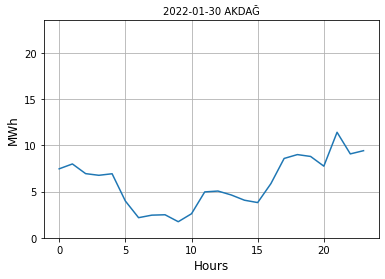

In [12]:
#%% PREDICTION

result = XGBoostRegression(X_train_append[maevalues.index(min(list(maevalues)))],
                           y_train_append[maevalues.index(min(list(maevalues)))],X_test)

installedcapacity=23.5
for ij in range(len(result)):
    if result[ij] > installedcapacity:
        result[ij]=installedcapacity
    elif result[ij] < 0:
        result[ij]=0
        
x = range(len(result))
ax = plt.figure().add_subplot(111)
ax.plot(x, list(result), linewidth=1.5)
ax.set_ylim(0, 23.5)
ax.set_title("{} AKDAĞ".format(end_date), fontsize=10)
ax.set_xlabel('Hours', fontsize=12)
ax.set_ylabel('MWh', fontsize=12)
ax.grid(True)

In [13]:
result

array([ 7.4545813,  7.9813933,  6.934918 ,  6.7549105,  6.921813 ,
        3.9799778,  2.174933 ,  2.4475207,  2.4897199,  1.7391056,
        2.5990257,  4.960167 ,  5.0529604,  4.631684 ,  4.062534 ,
        3.807382 ,  5.854872 ,  8.576041 ,  8.992362 ,  8.7920475,
        7.743213 , 11.40298  ,  9.067601 ,  9.415581 ], dtype=float32)